Accuracy: 0.921146953405018


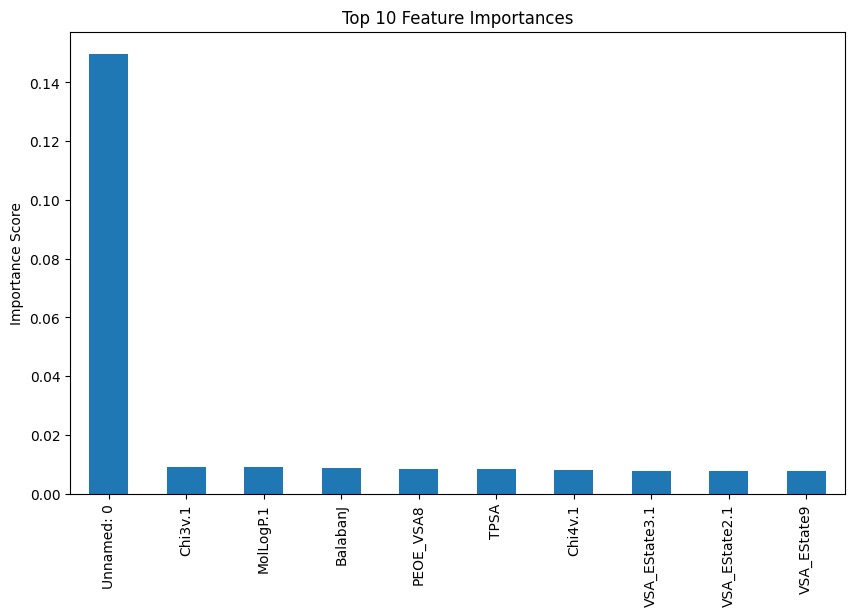

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

# Load the data
file_path = r"C:\Users\20223095\OneDrive - TU Eindhoven\Documents\GitHub\GroupAssigment_group6\tested_molecular_desc.csv"
df = pd.read_csv(file_path)

# Define the features and target variables
X = df.drop(columns=['SMILES', 'PKM2_inhibition', 'ERK2_inhibition'])
y = df[['PKM2_inhibition', 'ERK2_inhibition']]

# Convert data to float32
X = X.astype(np.float32)
y = y.astype(np.float32)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Adding the actual and predicted values to a new dataframe with molecule names
results_df = pd.DataFrame({
    'Molecule': df.loc[y_test.index, 'SMILES'],
    'PKM2_actual': y_test['PKM2_inhibition'].values,
    'ERK2_actual': y_test['ERK2_inhibition'].values,
    'PKM2_predicted': y_pred[:, 0],
    'ERK2_predicted': y_pred[:, 1]
})

# Save to new CSV
output_file_path = "predicted_molecules.csv"
results_df.to_csv(output_file_path, index=False)

# Feature importances
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
feature_imp.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.show()
